In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC

import string



In [2]:
X = pd.read_csv('acceleration_data1.csv', error_bad_lines=False, sep=";")

In [3]:
X.dropna(axis=0, subset=['FLAG'], inplace=True)
Y = X.FLAG
X.drop(['FLAG'], axis=1, inplace=True)
#ID may disturb model
X.drop(['ID'], axis=1, inplace=True)
cols_with_missing = [col for col in X.columns if X[col].isnull().any()] 
X.drop(cols_with_missing, axis=1, inplace=True)



In [4]:
X_split = pd.DataFrame(X.GEO.str.split(',',1).tolist(),
                                 columns = ['Axis1','Axis2'])

X.drop(['GEO'], axis=1, inplace=True)
X = pd.concat([X_split, X], axis=1, join="inner")

encoding_data = pd.get_dummies(X['SECTOR'], drop_first=True)
X.drop(['SECTOR'], axis=1, inplace=True)
X = pd.concat([encoding_data, X], axis=1, join="inner")

X['INCOME'] = X['INCOME'].apply(lambda x: x.replace(",", "."))
X['INCOME'] = X['INCOME'].str.extract(r'(\d+.\d+)').astype('float')

X['Axis1'] = X['Axis1'].str.extract(r'(\d+.\d+)').astype('float')
X['Axis2'] = X['Axis2'].str.extract(r'(\d+.\d+)').astype('float')

numerical_columns = [col for col in X if 
                    X[col].dtype in ['int64', 'float64']]
mm = MinMaxScaler()
for col in [numerical_columns]:
    X[col] = mm.fit_transform(X[col])

In [5]:
X_train, X_valid, y_train, y_valid = train_test_split(X, Y,
                                                      train_size=0.8, test_size=0.2,
                                                      random_state=0)

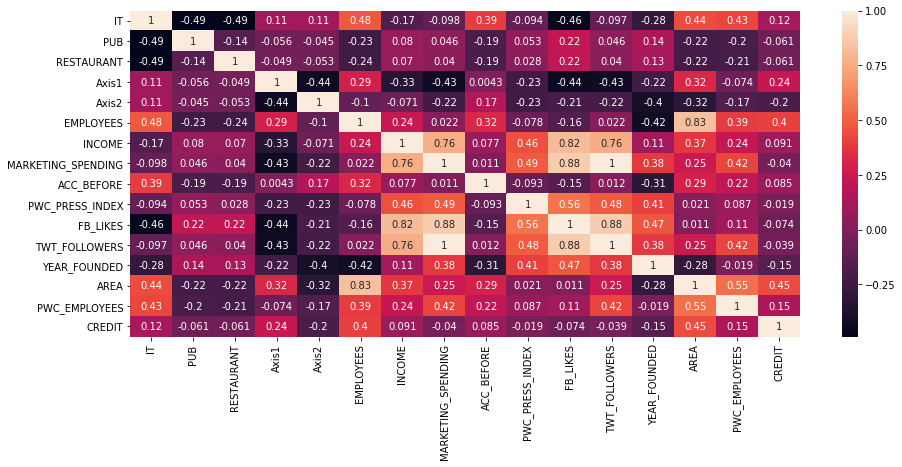

In [10]:
plt.figure(figsize = (15,6))
sns.heatmap(X.corr(), annot = True)

In [8]:
def check_randomforest(X_train, X_valid):
    model = RandomForestClassifier(n_estimators=100, random_state=1)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return accuracy_score(y_valid, preds)

In [9]:
check_randomforest(X_train, X_valid)

0.7495

In [24]:
model = RandomForestClassifier(n_estimators=100, random_state=1)
model.fit(X_train, y_train)
model.predict_proba([X.iloc[7201]])

array([[0.81, 0.19]])

In [9]:
def check_xdgb(X_train_data, X_valid_data):
    all_scores = []
    for early_stopping_rounds in [3, 5, 7]:
        for max_depth in [7, 9, 11]:
            for n_estimators in [200, 500, 1000]:
                for learning_rate in [0.02, 0.05, 0.1]:
                    for colsample_bytree in [0.5, 0.7, 0.9]:
                        for reg_alpha in [0.1, 1, 10, 100]:
                                XGBmodel = XGBClassifier(early_stopping_rounds=early_stopping_rounds,
                                                    max_depth=max_depth,
                                                   learning_rate=learning_rate,
                                                   colsample_bytree=colsample_bytree,
                                                   reg_alpha=reg_alpha,
                                                   reg_lambda=1,
                                                   objective ='reg:squarederror',
                                                   random_state=1,

                                                   )
                                XGBmodel.fit(X_train_data, y_train)
                                prediction = XGBmodel.predict(X_valid_data)
                                acc = accuracy_score(prediction, y_valid)
                                all_scores.append([early_stopping_rounds, max_depth, n_estimators,
                                                   learning_rate,colsample_bytree, reg_alpha, 
                                                acc])
                                print(all_scores[-1])
    max_scores_label = sorted(all_scores, key = lambda x: x[-1], reverse = True)[:5]
    print("5 BEST MODELS:")
    for i in max_scores_label:
        print(i)

In [10]:
check_xdgb(X_train, X_valid)
#0.765 best with not scaled data

[3, 7, 200, 0.02, 0.5, 0.1, 0.758]
[3, 7, 200, 0.02, 0.5, 1, 0.758]
[3, 7, 200, 0.02, 0.5, 10, 0.758]
[3, 7, 200, 0.02, 0.5, 100, 0.7385]
[3, 7, 200, 0.02, 0.7, 0.1, 0.7645]
[3, 7, 200, 0.02, 0.7, 1, 0.7605]
[3, 7, 200, 0.02, 0.7, 10, 0.7625]
[3, 7, 200, 0.02, 0.7, 100, 0.7445]
[3, 7, 200, 0.02, 0.9, 0.1, 0.7545]
[3, 7, 200, 0.02, 0.9, 1, 0.7565]
[3, 7, 200, 0.02, 0.9, 10, 0.764]
[3, 7, 200, 0.02, 0.9, 100, 0.749]
[3, 7, 200, 0.05, 0.5, 0.1, 0.751]
[3, 7, 200, 0.05, 0.5, 1, 0.754]
[3, 7, 200, 0.05, 0.5, 10, 0.761]
[3, 7, 200, 0.05, 0.5, 100, 0.7505]
[3, 7, 200, 0.05, 0.7, 0.1, 0.749]
[3, 7, 200, 0.05, 0.7, 1, 0.7575]
[3, 7, 200, 0.05, 0.7, 10, 0.7605]
[3, 7, 200, 0.05, 0.7, 100, 0.7555]
[3, 7, 200, 0.05, 0.9, 0.1, 0.7505]
[3, 7, 200, 0.05, 0.9, 1, 0.753]
[3, 7, 200, 0.05, 0.9, 10, 0.7535]
[3, 7, 200, 0.05, 0.9, 100, 0.7535]
[3, 7, 200, 0.1, 0.5, 0.1, 0.7465]
[3, 7, 200, 0.1, 0.5, 1, 0.751]
[3, 7, 200, 0.1, 0.5, 10, 0.7595]
[3, 7, 200, 0.1, 0.5, 100, 0.7515]
[3, 7, 200, 0.1, 0.7, 0.1, 0

[3, 11, 200, 0.05, 0.9, 0.1, 0.743]
[3, 11, 200, 0.05, 0.9, 1, 0.743]
[3, 11, 200, 0.05, 0.9, 10, 0.7475]
[3, 11, 200, 0.05, 0.9, 100, 0.7525]
[3, 11, 200, 0.1, 0.5, 0.1, 0.7535]
[3, 11, 200, 0.1, 0.5, 1, 0.7605]
[3, 11, 200, 0.1, 0.5, 10, 0.757]
[3, 11, 200, 0.1, 0.5, 100, 0.753]
[3, 11, 200, 0.1, 0.7, 0.1, 0.7395]
[3, 11, 200, 0.1, 0.7, 1, 0.744]
[3, 11, 200, 0.1, 0.7, 10, 0.7475]
[3, 11, 200, 0.1, 0.7, 100, 0.7515]
[3, 11, 200, 0.1, 0.9, 0.1, 0.737]
[3, 11, 200, 0.1, 0.9, 1, 0.741]
[3, 11, 200, 0.1, 0.9, 10, 0.7565]
[3, 11, 200, 0.1, 0.9, 100, 0.755]
[3, 11, 500, 0.02, 0.5, 0.1, 0.751]
[3, 11, 500, 0.02, 0.5, 1, 0.7545]
[3, 11, 500, 0.02, 0.5, 10, 0.758]
[3, 11, 500, 0.02, 0.5, 100, 0.742]
[3, 11, 500, 0.02, 0.7, 0.1, 0.743]
[3, 11, 500, 0.02, 0.7, 1, 0.7515]
[3, 11, 500, 0.02, 0.7, 10, 0.764]
[3, 11, 500, 0.02, 0.7, 100, 0.75]
[3, 11, 500, 0.02, 0.9, 0.1, 0.732]
[3, 11, 500, 0.02, 0.9, 1, 0.7365]
[3, 11, 500, 0.02, 0.9, 10, 0.7595]
[3, 11, 500, 0.02, 0.9, 100, 0.7485]
[3, 11, 500, 

[5, 9, 500, 0.02, 0.5, 10, 0.7555]
[5, 9, 500, 0.02, 0.5, 100, 0.7415]
[5, 9, 500, 0.02, 0.7, 0.1, 0.7515]
[5, 9, 500, 0.02, 0.7, 1, 0.7515]
[5, 9, 500, 0.02, 0.7, 10, 0.761]
[5, 9, 500, 0.02, 0.7, 100, 0.749]
[5, 9, 500, 0.02, 0.9, 0.1, 0.747]
[5, 9, 500, 0.02, 0.9, 1, 0.749]
[5, 9, 500, 0.02, 0.9, 10, 0.7595]
[5, 9, 500, 0.02, 0.9, 100, 0.7495]
[5, 9, 500, 0.05, 0.5, 0.1, 0.743]
[5, 9, 500, 0.05, 0.5, 1, 0.7455]
[5, 9, 500, 0.05, 0.5, 10, 0.757]
[5, 9, 500, 0.05, 0.5, 100, 0.75]
[5, 9, 500, 0.05, 0.7, 0.1, 0.7415]
[5, 9, 500, 0.05, 0.7, 1, 0.749]
[5, 9, 500, 0.05, 0.7, 10, 0.76]
[5, 9, 500, 0.05, 0.7, 100, 0.7565]
[5, 9, 500, 0.05, 0.9, 0.1, 0.749]
[5, 9, 500, 0.05, 0.9, 1, 0.7515]
[5, 9, 500, 0.05, 0.9, 10, 0.749]
[5, 9, 500, 0.05, 0.9, 100, 0.7535]
[5, 9, 500, 0.1, 0.5, 0.1, 0.742]
[5, 9, 500, 0.1, 0.5, 1, 0.7415]
[5, 9, 500, 0.1, 0.5, 10, 0.7565]
[5, 9, 500, 0.1, 0.5, 100, 0.752]
[5, 9, 500, 0.1, 0.7, 0.1, 0.7425]
[5, 9, 500, 0.1, 0.7, 1, 0.749]
[5, 9, 500, 0.1, 0.7, 10, 0.7565]
[

[7, 7, 500, 0.05, 0.7, 100, 0.7555]
[7, 7, 500, 0.05, 0.9, 0.1, 0.7505]
[7, 7, 500, 0.05, 0.9, 1, 0.753]
[7, 7, 500, 0.05, 0.9, 10, 0.7535]
[7, 7, 500, 0.05, 0.9, 100, 0.7535]
[7, 7, 500, 0.1, 0.5, 0.1, 0.7465]
[7, 7, 500, 0.1, 0.5, 1, 0.751]
[7, 7, 500, 0.1, 0.5, 10, 0.7595]
[7, 7, 500, 0.1, 0.5, 100, 0.7515]
[7, 7, 500, 0.1, 0.7, 0.1, 0.748]
[7, 7, 500, 0.1, 0.7, 1, 0.7565]
[7, 7, 500, 0.1, 0.7, 10, 0.752]
[7, 7, 500, 0.1, 0.7, 100, 0.7535]
[7, 7, 500, 0.1, 0.9, 0.1, 0.7495]
[7, 7, 500, 0.1, 0.9, 1, 0.75]
[7, 7, 500, 0.1, 0.9, 10, 0.756]
[7, 7, 500, 0.1, 0.9, 100, 0.7575]
[7, 7, 1000, 0.02, 0.5, 0.1, 0.758]
[7, 7, 1000, 0.02, 0.5, 1, 0.758]
[7, 7, 1000, 0.02, 0.5, 10, 0.758]
[7, 7, 1000, 0.02, 0.5, 100, 0.7385]
[7, 7, 1000, 0.02, 0.7, 0.1, 0.7645]
[7, 7, 1000, 0.02, 0.7, 1, 0.7605]
[7, 7, 1000, 0.02, 0.7, 10, 0.7625]
[7, 7, 1000, 0.02, 0.7, 100, 0.7445]
[7, 7, 1000, 0.02, 0.9, 0.1, 0.7545]
[7, 7, 1000, 0.02, 0.9, 1, 0.7565]
[7, 7, 1000, 0.02, 0.9, 10, 0.764]
[7, 7, 1000, 0.02, 0.9, 1

[7, 11, 1000, 0.02, 0.5, 10, 0.758]
[7, 11, 1000, 0.02, 0.5, 100, 0.742]
[7, 11, 1000, 0.02, 0.7, 0.1, 0.743]
[7, 11, 1000, 0.02, 0.7, 1, 0.7515]
[7, 11, 1000, 0.02, 0.7, 10, 0.764]
[7, 11, 1000, 0.02, 0.7, 100, 0.75]
[7, 11, 1000, 0.02, 0.9, 0.1, 0.732]
[7, 11, 1000, 0.02, 0.9, 1, 0.7365]
[7, 11, 1000, 0.02, 0.9, 10, 0.7595]
[7, 11, 1000, 0.02, 0.9, 100, 0.7485]
[7, 11, 1000, 0.05, 0.5, 0.1, 0.7495]
[7, 11, 1000, 0.05, 0.5, 1, 0.743]
[7, 11, 1000, 0.05, 0.5, 10, 0.758]
[7, 11, 1000, 0.05, 0.5, 100, 0.751]
[7, 11, 1000, 0.05, 0.7, 0.1, 0.7415]
[7, 11, 1000, 0.05, 0.7, 1, 0.745]
[7, 11, 1000, 0.05, 0.7, 10, 0.761]
[7, 11, 1000, 0.05, 0.7, 100, 0.756]
[7, 11, 1000, 0.05, 0.9, 0.1, 0.743]
[7, 11, 1000, 0.05, 0.9, 1, 0.743]
[7, 11, 1000, 0.05, 0.9, 10, 0.7475]
[7, 11, 1000, 0.05, 0.9, 100, 0.7525]
[7, 11, 1000, 0.1, 0.5, 0.1, 0.7535]
[7, 11, 1000, 0.1, 0.5, 1, 0.7605]
[7, 11, 1000, 0.1, 0.5, 10, 0.757]
[7, 11, 1000, 0.1, 0.5, 100, 0.753]
[7, 11, 1000, 0.1, 0.7, 0.1, 0.7395]
[7, 11, 1000, 0

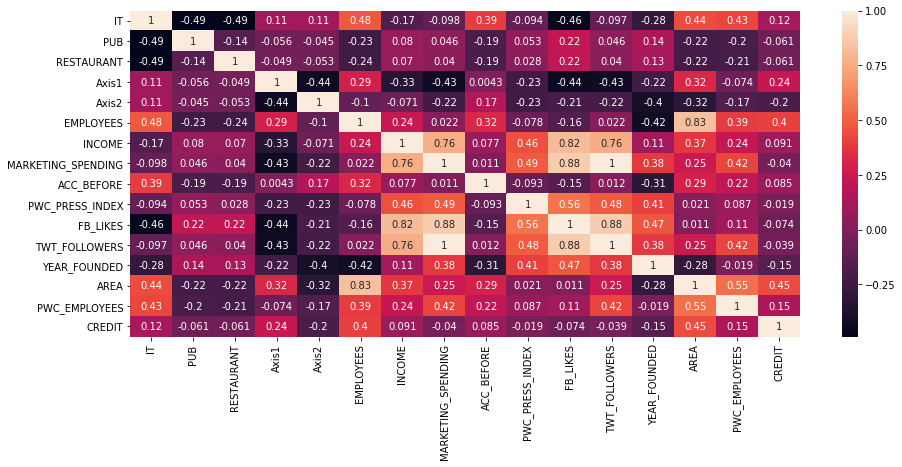

In [28]:
plt.figure(figsize = (15,6))
sns.heatmap(X.corr(), annot = True)

In [46]:
object_cols = [col for col in X_train.columns if X_train[col].dtype == "object"]
good_label_cols = [col for col in object_cols if 
                   set(X_train[col]) == set(X_valid[col])]
object_cols


[]

In [12]:
X

,IT,PUB,RESTAURANT,Axis1,Axis2,EMPLOYEES,INCOME,MARKETING_SPENDING,ACC_BEFORE,PWC_PRESS_INDEX,FB_LIKES,TWT_FOLLOWERS,YEAR_FOUNDED,AREA,PWC_EMPLOYEES,CREDIT
0,0,1,0,21.001716,52.231406,0.016129,150426.0,0.105924,0.0,0.311094,0.226698,0.087518,0.84,0.055851,0.000000,0.002266
1,0,1,0,21.006869,52.233266,0.080645,500078.0,0.436258,0.0,0.565432,0.887533,0.422525,0.88,0.087766,0.066667,0.004180
2,1,0,0,21.074607,52.279005,0.419355,199767.0,0.061470,0.0,0.318759,0.058218,0.064562,0.64,0.191489,0.000000,0.000786
3,1,0,0,21.012082,52.232082,0.064516,109200.0,0.091759,1.0,0.404416,0.083799,0.071736,0.88,0.026596,0.066667,0.000748
4,1,0,0,21.000125,52.239957,0.032258,112200.0,0.121307,0.0,0.402546,0.122758,0.111908,0.92,0.031915,0.000000,0.000672
5,1,0,0,21.028944,52.223418,0.258065,337500.0,0.550557,1.0,0.424799,0.535137,0.539455,0.72,0.454787,0.400000,0.005349
6,1,0,0,21.013399,52.239528,0.387097,382750.0,0.462509,1.0,0.415240,0.448839,0.502869,0.88,0.484043,0.400000,0.005327
7,1,0,0,21.134521,52.181435,0.032258,71947.0,0.106370,0.0,0.414141,0.105704,0.113343,0.84,0.170213,0.000000,0.002238
8,1,0,0,21.066008,52.281070,0.016129,199999.0,0.063771,1.0,0.346095,0.065422,0.050933,0.56,0.162234,0.133333,0.000801
9,1,0,0,21.027735,52.224969,0.048387,138500.0,0.226281,1.0,0.416401,0.223758,0.207317,0.84,0.018617,0.066667,0.000901


In [29]:
X.head()

,IT,PUB,RESTAURANT,Axis1,Axis2,EMPLOYEES,INCOME,MARKETING_SPENDING,ACC_BEFORE,PWC_PRESS_INDEX,FB_LIKES,TWT_FOLLOWERS,YEAR_FOUNDED,AREA,PWC_EMPLOYEES,CREDIT
0,0,1,0,0.008550,0.472204,0.016129,0.232496,0.105924,0.0,0.311094,0.226698,0.087518,0.84,0.055851,0.000000,0.002266
1,0,1,0,0.034315,0.486518,0.080645,0.772918,0.436258,0.0,0.565432,0.887533,0.422525,0.88,0.087766,0.066667,0.004180
2,1,0,0,0.373037,0.838522,0.419355,0.308758,0.061470,0.0,0.318759,0.058218,0.064562,0.64,0.191489,0.000000,0.000786
3,1,0,0,0.060385,0.477410,0.064516,0.168778,0.091759,1.0,0.404416,0.083799,0.071736,0.88,0.026596,0.066667,0.000748
4,1,0,0,0.000593,0.538015,0.032258,0.173414,0.121307,0.0,0.402546,0.122758,0.111908,0.92,0.031915,0.000000,0.000672


In [30]:
#SECTOR NEEDS TO BEE ENCODED
X.dtypes
# X.SECTOR.value_counts()

IT                      uint8
PUB                     uint8
RESTAURANT              uint8
Axis1                 float64
Axis2                 float64
EMPLOYEES             float64
INCOME                float64
MARKETING_SPENDING    float64
ACC_BEFORE            float64
PWC_PRESS_INDEX       float64
FB_LIKES              float64
TWT_FOLLOWERS         float64
YEAR_FOUNDED          float64
AREA                  float64
PWC_EMPLOYEES         float64
CREDIT                float64
dtype: object

KeyError: 'FLAG'

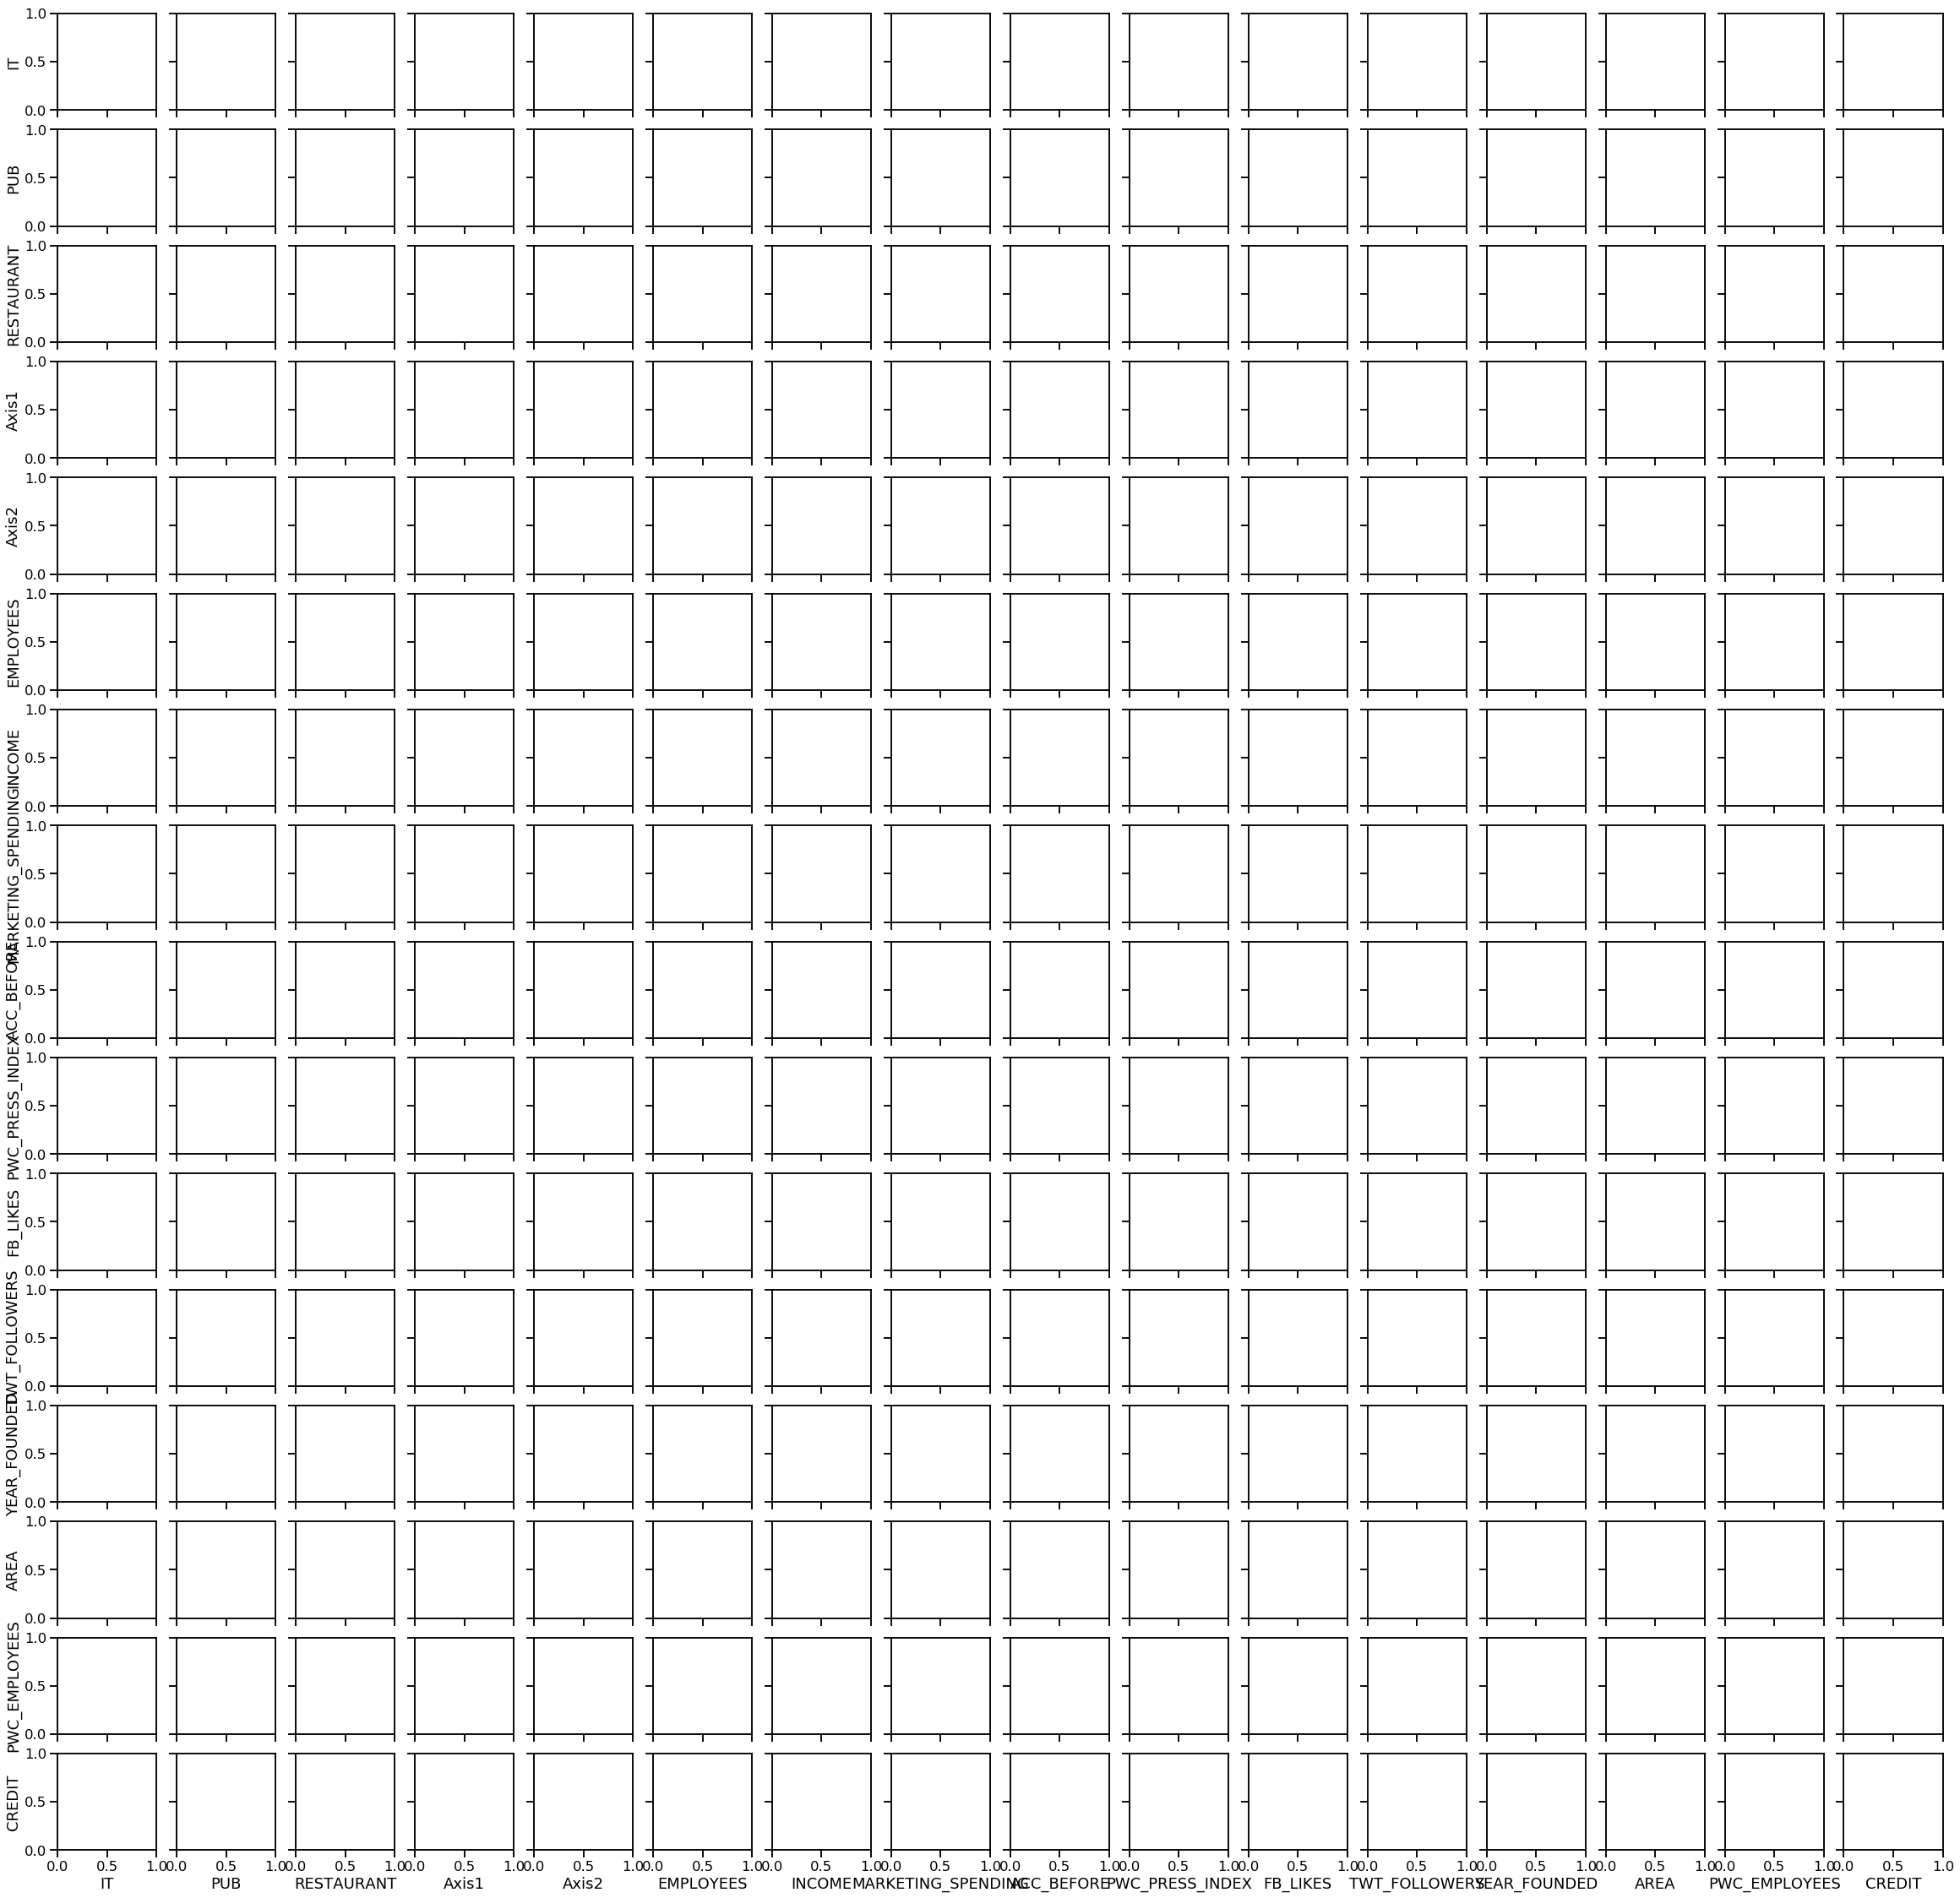

In [31]:
sns.set_context('talk')
plot = sns.pairplot(X, hue='FLAG')
plot._legend.remove()
plot

In [39]:
cols_with_missing = [col for col in X.columns if X[col].isnull().any()] 
cols_with_missing

['EXP_CEO']

In [10]:
KNN = KNeighborsClassifier(n_neighbors=3)

In [12]:
def check_KNN(X_train, X_valid):
    all_scores = []
    for n_neighbors in range(1,250):
        model = KNeighborsClassifier(n_neighbors=n_neighbors, weights='distance', p=2)
        model.fit(X_train, y_train)
        preds = model.predict(X_valid)
        acc = accuracy_score(preds, y_valid)
        all_scores.append([n_neighbors, acc])
    max_scores_label = sorted(all_scores, key = lambda x: x[-1], reverse = True)[:5]
    print("5 BEST MODELS:")
    for i in max_scores_label:
        print(i)
#     print("K=", n_neighbors, "ACC=", accuracy_score(y_valid, preds))
#     return accuracy_score(y_valid, preds)

In [13]:
check_KNN(X_train, X_valid)

5 BEST MODELS:
[38, 0.747]
[53, 0.7465]
[51, 0.746]
[56, 0.746]
[57, 0.746]


In [22]:
model = KNeighborsClassifier(n_neighbors=27)
model.fit(X_train, y_train)
preds = model.predict(X_valid)
print(classification_report(y_valid, preds))

              precision    recall  f1-score   support

           0       0.80      0.63      0.70       970
           1       0.71      0.85      0.77      1030

    accuracy                           0.74      2000
   macro avg       0.75      0.74      0.74      2000
weighted avg       0.75      0.74      0.74      2000



In [6]:
def check_SVM(X_train, X_valid):
    all_scores = []
    for C in np.logspace(-3, 2, 24):
        for kernel in ['rbf', 'linear', 'poly', 'sigmoid']:
            if kernel == 'poly':
                degrees = [2,3,4]
            else:
                degrees = [1]

            for degree in degrees:
                model = SVC(C=C, cache_size=500, kernel=kernel, degree=degree,
                    max_iter=-1, probability=True,
                    tol=0.001, verbose=False)
                model.fit(X_train, y_train)
                preds = model.predict(X_valid)
                acc = accuracy_score(preds, y_valid)
                all_scores.append([C, kernel, degree, acc])
                print(C, kernel, degree, acc)
    max_scores_label = sorted(all_scores, key = lambda x: x[-1], reverse = True)[:5]
    print("5 BEST MODELS:")
    for i in max_scores_label:
        print(i)

In [7]:
check_SVM(X_train, X_valid)

0.001 rbf 1 0.515
0.001 linear 1 0.65
0.001 poly 2 0.717
0.001 poly 3 0.719
0.001 poly 4 0.7225
0.001 sigmoid 1 0.515
0.0016496480740980208 rbf 1 0.5875
0.0016496480740980208 linear 1 0.6475
0.0016496480740980208 poly 2 0.7165
0.0016496480740980208 poly 3 0.7235
0.0016496480740980208 poly 4 0.7235
0.0016496480740980208 sigmoid 1 0.515
0.002721338768375309 rbf 1 0.7175
0.002721338768375309 linear 1 0.7075
0.002721338768375309 poly 2 0.722
0.002721338768375309 poly 3 0.724
0.002721338768375309 poly 4 0.722
0.002721338768375309 sigmoid 1 0.5155
0.004489251258218608 rbf 1 0.71
0.004489251258218608 linear 1 0.7185
0.004489251258218608 poly 2 0.7265
0.004489251258218608 poly 3 0.7255
0.004489251258218608 poly 4 0.724
0.004489251258218608 sigmoid 1 0.6215
0.007405684692262435 rbf 1 0.7135
0.007405684692262435 linear 1 0.722
0.007405684692262435 poly 2 0.7275
0.007405684692262435 poly 3 0.7275
0.007405684692262435 poly 4 0.7265
0.007405684692262435 sigmoid 1 0.637
0.012216773489967919 rbf 1 0.

In [ ]:
BEST 5 XGB BEST MODELS:
[3, 7, 200, 0.02, 0.7, 0.1, 0.7645]
[3, 7, 500, 0.02, 0.7, 0.1, 0.7645]
[3, 7, 1000, 0.02, 0.7, 0.1, 0.7645]
[5, 7, 200, 0.02, 0.7, 0.1, 0.7645]
[5, 7, 500, 0.02, 0.7, 0.1, 0.7645]

5 BEST SVM MODELS:
[100.0, 'poly', 4, 0.7465]
[4.961947603002903, 'poly', 4, 0.7455]
[13.503140378698722, 'poly', 3, 0.7455]
[22.275429519995562, 'poly', 3, 0.7455]
[22.275429519995562, 'rbf', 1, 0.745]

5 BEST KNN MODELS:
[38, 0.747]
[53, 0.7465]
[51, 0.746]
[56, 0.746]
[57, 0.746]